## SNPE applied to SFH 

We want to infer the percentiles of stellar mass of galaxies from their spectra (whose dimensions have been reduced using an autoencoder with an attention module from 4300 points to 16-component latent vectors)

We load the modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sbi import utils as Ut
from sbi import inference as Inference
import pickle
from tqdm import tqdm

We load the percentiles and latent vectors

(100000, 16)
(100000, 9)


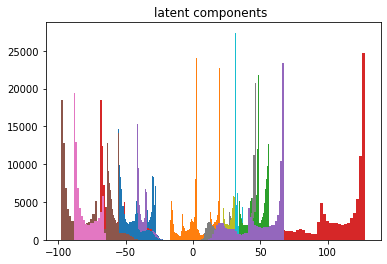

In [2]:
latents_batch=np.load('./saved_models/latents_1e5.npy',allow_pickle=True)
percentiles=np.load('./saved_models/percentiles_1e5.npy',allow_pickle=True)
latents=np.zeros((100000,16))
batch_size=128

#to create a single dataset with all the minibatches
for j in range(len(latents_batch)):
    for i,x in enumerate(latents_batch[j]):
        latents[batch_size*j+i,:]=x
        
print(np.shape(latents))
print(np.shape(percentiles))

#for checking distributions

for i in range(16):
    plt.hist(latents[:,i],bins=40,label='l'+str(i+1))
#plt.legend()
plt.title('latent components ')
plt.show()



13.453503482650405


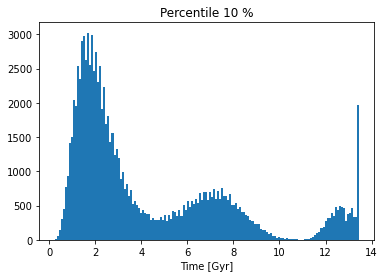

13.453503482650405


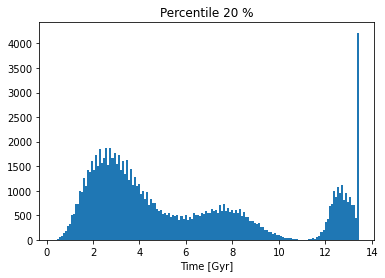

13.453503482650405


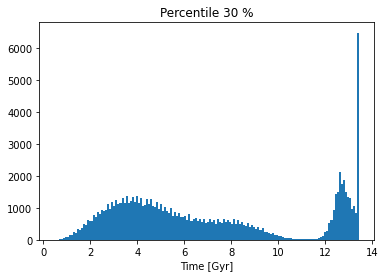

13.453503482650405


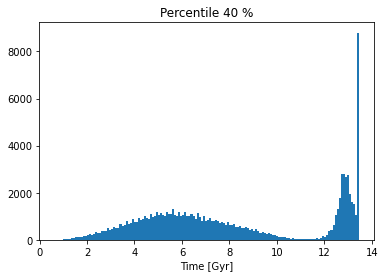

13.453503482650405


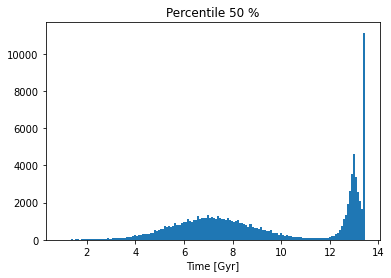

13.466983947061877


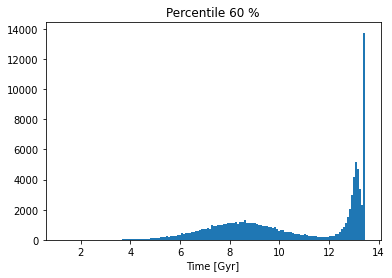

13.466983947061877


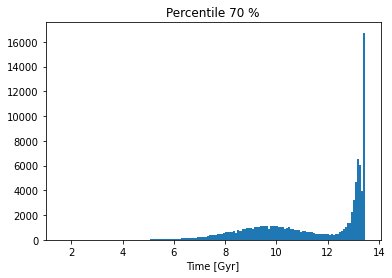

13.466983947061877


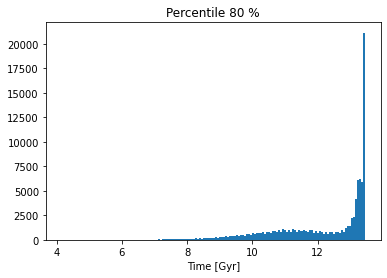

13.466983947061877


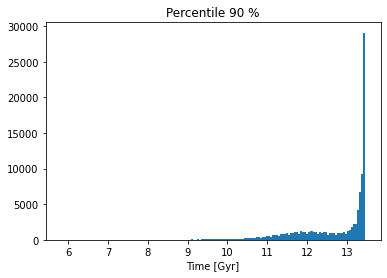

In [3]:
for i in range(9):
    plt.hist(percentiles[:,i],bins=150)
    plt.title('Percentile '+str((i+1)*10)+' %')
    plt.xlabel('Time [Gyr]')
    print(np.max(percentiles[:,i]))
    plt.show()

We shuffle and save the indexes shuffled, or we just load them

In [4]:
#training with the first 90.000 elements of the dataset (previously shuffled) 

#index_sh=np.arange(100000)
#np.random.shuffle(index_sh)
#np.save('./saved_models/ind_sh_1e5.npy',index_sh)
index_sh=np.load('./saved_models/ind_sh_1e5.npy')

x=latents[index_sh[:90000],:]
theta=percentiles[index_sh[:90000],:]

We define the range for the posterior estimation (wrongly called prior) - all of them uniformly distributed between 0 and 14

In [5]:
lower_bounds = -2*torch.ones(np.shape(theta[0,:]))
upper_bounds = 16*torch.ones(np.shape(theta[0,:]))
bounds = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device='cpu')

We define the model and train, then save the model

In [6]:
nhidden = 128 
nblocks = 5
maf_model = Ut.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks)

anpe = Inference.SNPE(prior=bounds,
                      density_estimator=maf_model,
                      device='cpu')

#anpe, amortized neural posterior estimation
anpe.append_simulations(
            torch.as_tensor(theta.astype(np.float32)).to('cpu'),
            torch.as_tensor(x.astype(np.float32)).to('cpu'))  

# estimate p(theta|X), the posterior
p_theta_x_est = anpe.train()
qphi = anpe.build_posterior(p_theta_x_est)

 Neural network successfully converged after 126 epochs.

Save posterior or load it

In [7]:


file='./saved_models/my_posterior.pkl'
with open(file, "wb") as handle:
    pickle.dump(qphi, handle)

handle.close()


"""

file = open(file, 'rb')
qphi = pickle.load(file)
file.close()
"""

"\n\nfile = open(file, 'rb')\nqphi = pickle.load(file)\nfile.close()\n"

We create a function to see real vs predicted percentiles (we plot the mean and the interval of confidence: sigma, 2sigma... of the posteriors) for the test dataset (10.000 samples)

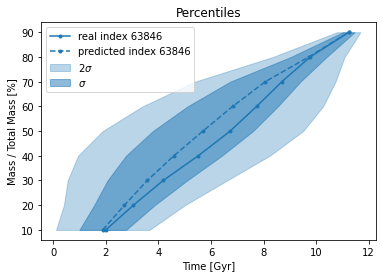

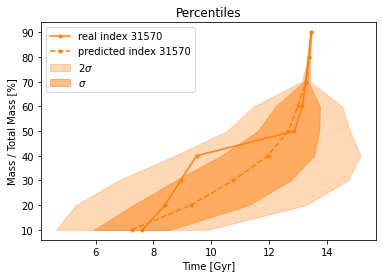

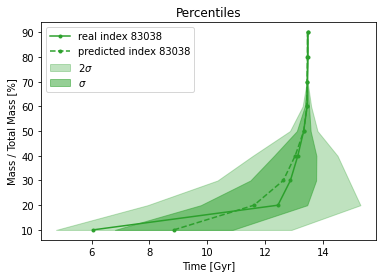

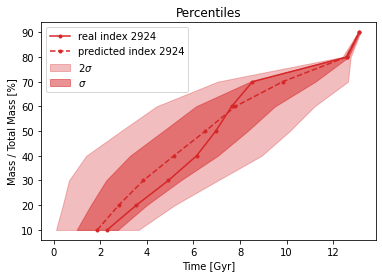

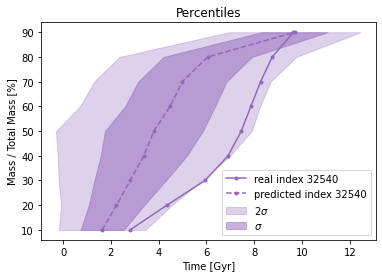

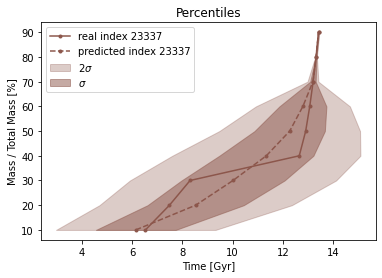

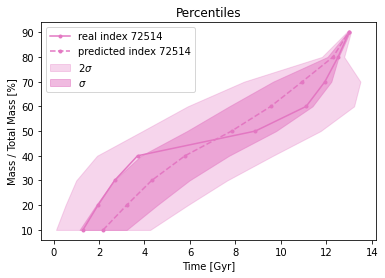

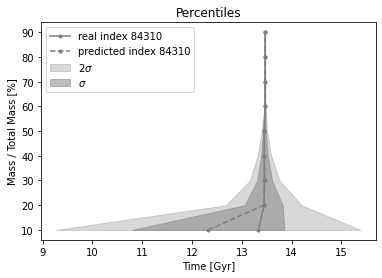

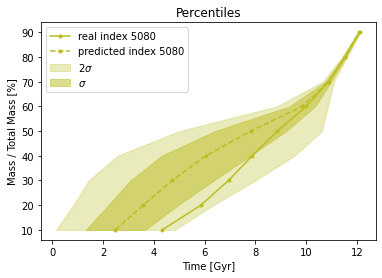

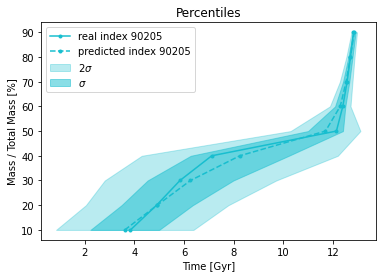

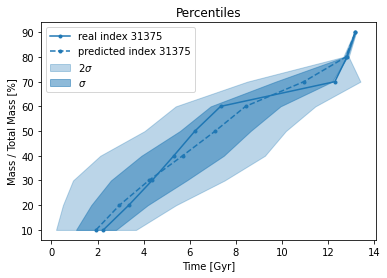

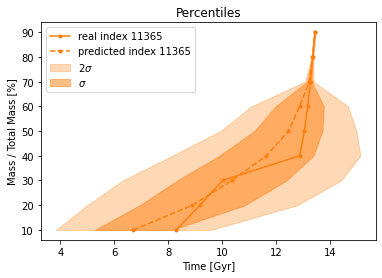

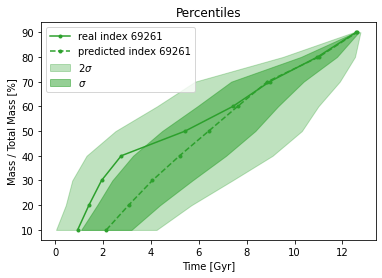

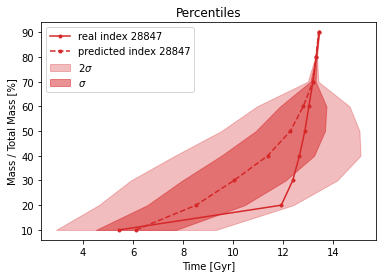

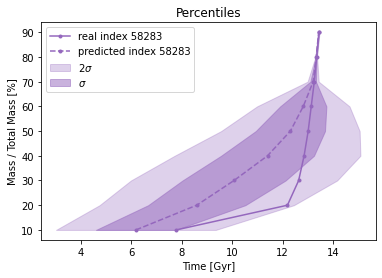

In [8]:
def plot_percentile_distribution(i,index_list=np.random.randint(90000,100000,15),mean=False,real_plot=False):
    
    if i==None:
        for k,j in enumerate(index_list):
                #if index_sh[j]>5000:
                Xobs=latents[index_sh[j],:]
                posterior_samples= np.array(qphi.sample((10000,), 
                                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                                        show_progress_bars=False).detach().to('cpu'))
                
                plt.plot(percentiles[index_sh[j],:],np.arange(10,100,10),'.-',color='C'+str(k),label='real index '+str(index_sh[j]))
                plt.plot(np.mean(posterior_samples,axis=0),np.arange(10,100,10),'.--',color='C'+str(k),label='predicted index '+str(index_sh[j]))
                plt.fill_betweenx(np.arange(10,100,10),np.mean(posterior_samples,axis=0)+2*np.std(posterior_samples[:,:],axis=0),np.mean(posterior_samples,axis=0)-2*np.std(posterior_samples[:,:],axis=0),color='C'+str(k),alpha=0.3,label='$2\\sigma$')
                plt.fill_betweenx(np.arange(10,100,10),np.mean(posterior_samples,axis=0)+np.std(posterior_samples[:,:],axis=0),np.mean(posterior_samples,axis=0)-np.std(posterior_samples[:,:],axis=0),color='C'+str(k),alpha=0.5,label='$\\sigma$')
                plt.title('Percentiles')
                plt.legend()
                plt.xlabel('Time [Gyr]')
                plt.ylabel('Mass / Total Mass [%]')
                #plt.savefig('prediction_1e5_m216_'+str(k)+'.jpg')
                plt.show()

        
    else:
         for k,j in enumerate(index_list):
                #if index_sh[j]>5000:
                Xobs=latents[index_sh[j],:]
                posterior_samples= np.array(qphi.sample((10000,), 
                                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                                        show_progress_bars=False).detach().to('cpu'))

                plt.hist(posterior_samples[:,i-1],alpha=0.5,color='C'+str(k),label='index '+str(index_sh[j]))

                if mean:
                    plt.axvline(np.mean(posterior_samples[:,i-1]),ls='--',color='C'+str(k))
                    plt.axvline(percentiles[index_sh[j],i-1],ls='-',color='C'+str(k))
         
        
         plt.title('percentil posterior ' +str(i*10)+'%')
         #plt.legend()
         plt.xlabel('Time [Gyr]')
         plt.show()
            
         if real_plot:
            for k,j in enumerate(index_list):
                #if index_sh[j]>5000:
                plt.plot(percentiles[index_sh[j],:],np.arange(10,100,10),'.-',color='C'+str(k),label='index '+str(index_sh[j]))
            plt.title('Real percentiles')
            plt.xlabel('Time [Gyr]')
            plt.ylabel('Mass / Total Mass [%]')
            #plt.legend()
            plt.show()
    

    
#plot_percentile_distribution(1,mean=True)
#plot_percentile_distribution(5,mean=True)
#plot_percentile_distribution(9,mean=True,real_plot=True)
plot_percentile_distribution(None)

We plot the mean of the predicted posteriors (and save it after computed) vs the ground truth

In [10]:
n_evaluations=10000
n_samples=1000
index_list=np.arange(90000,100000)

stds=[]
means=[]

for k,j in tqdm(enumerate(index_list)):
    Xobs=latents[index_sh[j],:]
    posterior_samples= np.array(qphi.sample((n_samples,), x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), show_progress_bars=False).detach().to('cpu'))
    stds.append(np.std(posterior_samples,axis=0))
    means.append(np.mean(posterior_samples,axis=0))

np.save('./saved_models/means.npy',means)
np.save('./saved_models/stds.npy',stds)

10000it [1:01:00,  2.73it/s]


[[ 6.88851731  8.16916143 12.5772733  ... 13.25129652 13.35914023
  13.45350348]
 [12.33462494 12.75251933 13.00864816 ... 13.45350348 13.46698395
  13.46698395]
 [ 6.09316991 11.9706524  12.40202726 ... 13.17041373 13.30521837
  13.42654255]
 ...
 [ 6.26841595  7.61646239 12.36158587 ... 13.15693327 13.29173791
  13.39958163]
 [ 6.45714245  7.75126704 12.22678122 ... 13.18389419 13.29173791
  13.39958163]
 [ 5.94488481 12.01109379 12.44246865 ... 13.19737466 13.3321793
  13.44002302]]


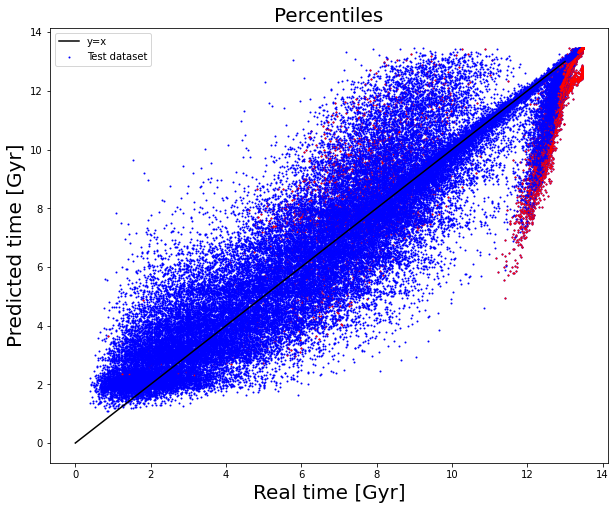

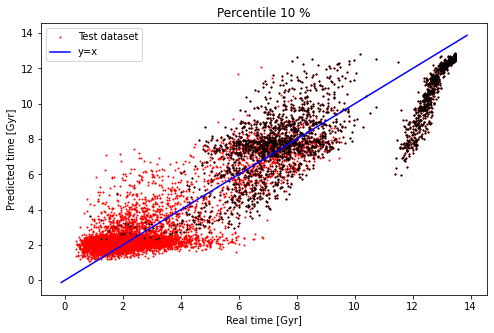

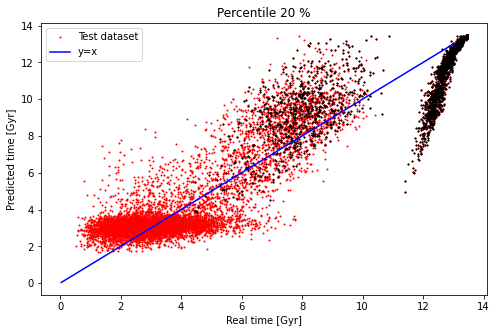

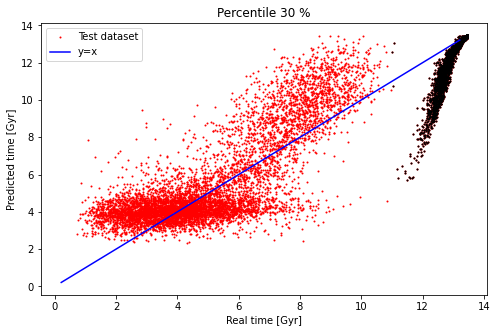

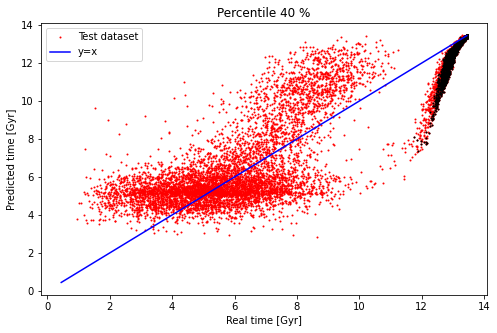

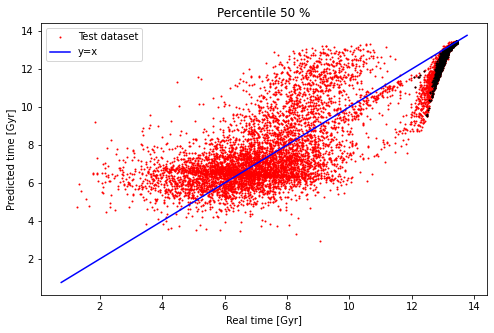

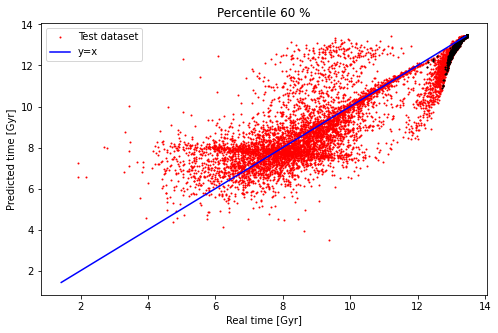

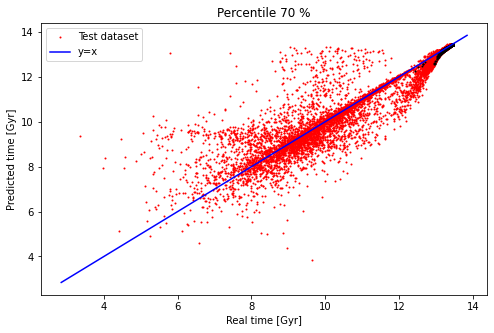

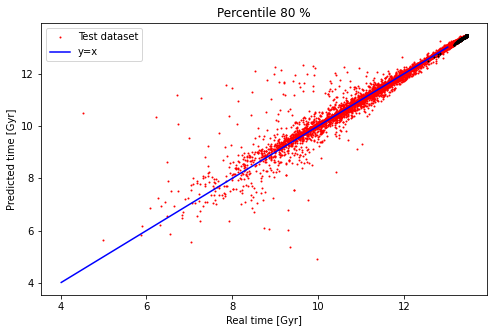

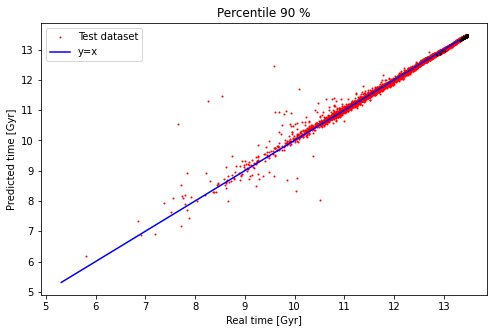

In [11]:
means=np.load('./saved_models/means.npy')
stds=np.load('./saved_models/stds.npy')

#all together
plt.figure(figsize=(10,8))

index_weird=np.where(percentiles[index_sh[index_list],2]>11)[0]

print(percentiles[index_sh[index_list][index_weird],:])

for i in range(9):
    if i==0:
        plt.plot(np.arange(14),np.arange(14),label='y=x',color='k')
        plt.scatter(percentiles[index_sh[index_list],i],means[:,i],s=1,color='b',label='Test dataset')#,label=str((i+1)*10)+' %')
    else:
        plt.scatter(percentiles[index_sh[index_list],i],means[:,i],s=1,color='b')#,label=str((i+1)*10)+' %')
    
    plt.scatter(percentiles[index_sh[index_list][index_weird],i],means[index_weird,i],s=1,color='r')
        
plt.xlabel('Real time [Gyr]',fontsize=20)
plt.ylabel('Predicted time [Gyr]',fontsize=20)
plt.legend(fontsize=10)
plt.title('Percentiles',fontsize=20)
#plt.savefig('1e5_m216_pred_vs_true.jpg')
plt.show()

#one by one
for i in range(9):
    p=percentiles[index_sh[index_list],i]
    x=np.arange(np.min(p)-0.5,np.max(p)+0.5)
    plt.figure(figsize=(8,5))
    plt.scatter(p,means[:,i],s=1,color='r',label='Test dataset')
    #plt.errorbar(percentiles[index_sh[index_list],i],means[:,i],yerr=stds[:,i],fmt='bo')


    plt.plot(x,x,label='y=x',color='b')
    plt.xlabel('Real time [Gyr]')
    plt.ylabel('Predicted time [Gyr]')
    plt.legend()
    plt.title('Percentile '+str((i+1)*10)+' %')
    #plt.savefig('1e5_m216_prediction'+str(i)+'.jpg')
    
    plt.scatter(percentiles[index_sh[index_list][index_weird],i],means[index_weird,i],s=1,color='k')
    
    plt.show()
    
    




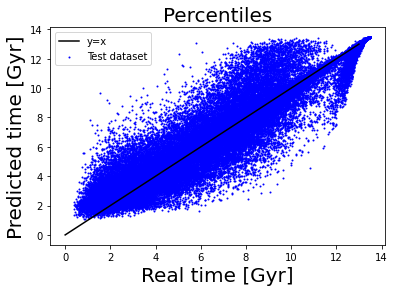

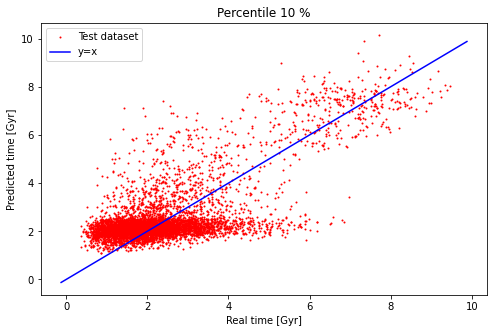

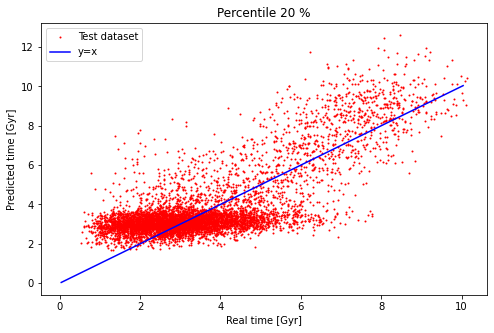

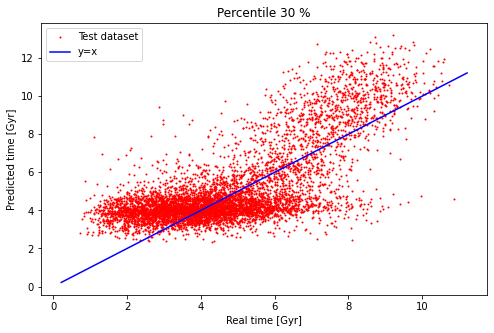

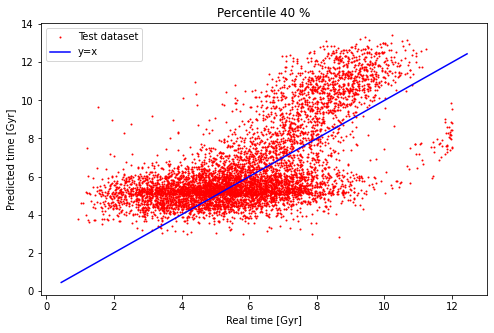

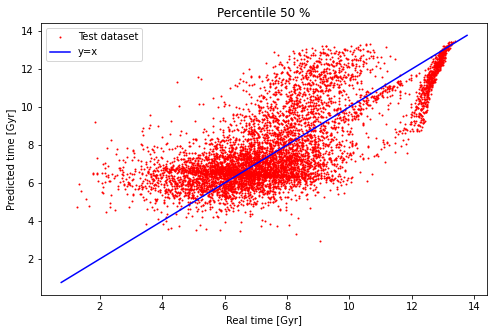

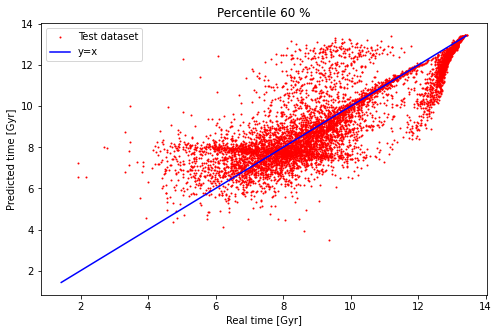

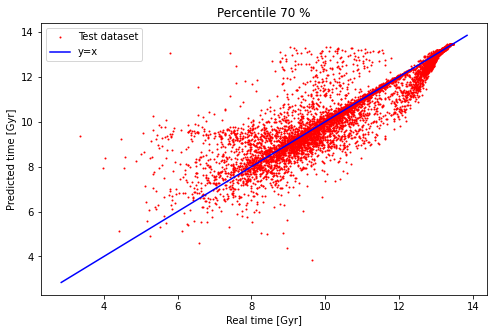

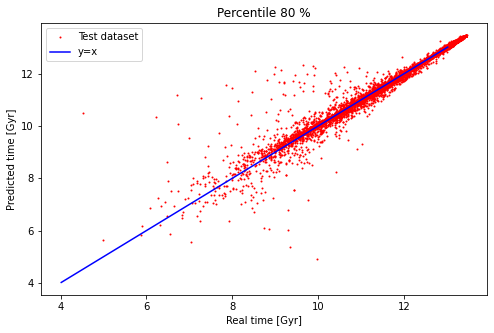

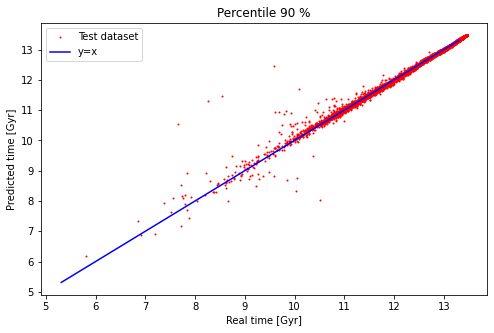

In [23]:
#p=percentiles[index_sh[index_list],:]
index_ok=np.where((percentiles[index_sh[index_list],2]<11)&(percentiles[index_sh[index_list],3]<12))[0]
#index_ok=np.arange(10000)

for i in range(9):
    if i==0:
        plt.plot(np.arange(14),np.arange(14),label='y=x',color='k')
        plt.scatter(percentiles[index_sh[index_list][index_ok],i],means[index_ok,i],s=1,color='b',label='Test dataset')#,label=str((i+1)*10)+' %')
    else:
        plt.scatter(percentiles[index_sh[index_list][index_ok],i],means[index_ok,i],s=1,color='b')#,label=str((i+1)*10)+' %')

        
plt.xlabel('Real time [Gyr]',fontsize=20)
plt.ylabel('Predicted time [Gyr]',fontsize=20)
plt.legend(fontsize=10)
plt.title('Percentiles',fontsize=20)
#plt.savefig('1e5_m216_pred_vs_true.jpg')
plt.show()

#one by one
for i in range(9):
    p=percentiles[index_sh[index_list][index_ok],i]
    x=np.arange(np.min(p)-0.5,np.max(p)+0.5)
    plt.figure(figsize=(8,5))
    plt.scatter(p,means[index_ok,i],s=1,color='r',label='Test dataset')
    #plt.errorbar(percentiles[index_sh[index_list],i],means[:,i],yerr=stds[:,i],fmt='bo')


    plt.plot(x,x,label='y=x',color='b')
    plt.xlabel('Real time [Gyr]')
    plt.ylabel('Predicted time [Gyr]')
    plt.legend()
    plt.title('Percentile '+str((i+1)*10)+' %')
    #plt.savefig('1e5_m216_prediction'+str(i)+'.jpg')
    plt.show()
    
    


In [27]:
means_ok=means[index_ok,:]
stds_ok=stds[index_ok,:]
np.save('./saved_models/means_ok.npy',means_ok)
np.save('./saved_models/stds_ok.npy',stds_ok)
np.save('./saved_models/index_ok.npy',index_ok)

2561
[   0    4    6 ... 9966 9975 9986]


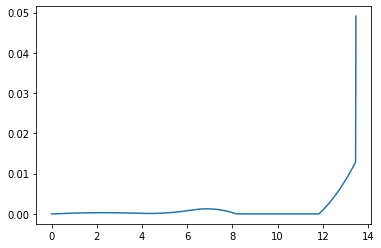

[ 5.81008016  7.07724382 12.25374215 12.60423422 12.83340212 13.00864816
 13.15693327 13.27825745 13.39958163]


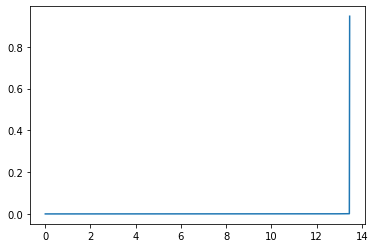

[13.45350348 13.45350348 13.45350348 13.45350348 13.45350348 13.46698395
 13.46698395 13.46698395 13.46698395]


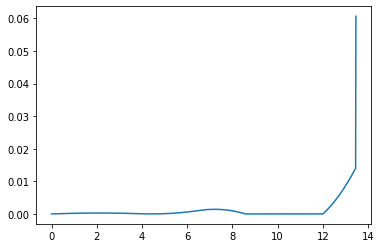

[ 6.4032206   7.45469682 12.3481054  12.68511701 12.90080444 13.06257001
 13.19737466 13.30521837 13.41306209]


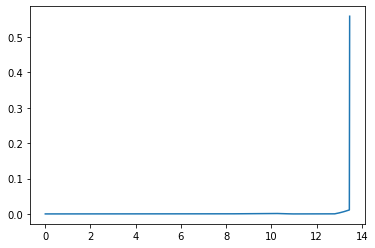

[ 9.67897345 12.9547263  13.25129652 13.39958163 13.45350348 13.45350348
 13.45350348 13.46698395 13.46698395]


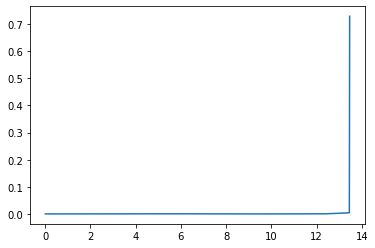

[12.41550772 13.18389419 13.45350348 13.45350348 13.45350348 13.45350348
 13.46698395 13.46698395 13.46698395]


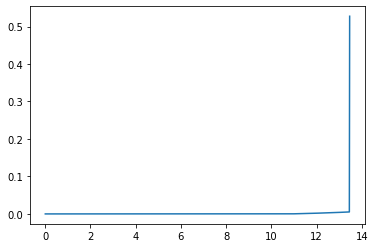

[12.02457426 12.56379283 12.9547263  13.26477698 13.45350348 13.45350348
 13.45350348 13.46698395 13.46698395]


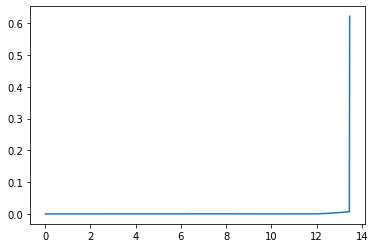

[12.63119515 13.03560909 13.29173791 13.45350348 13.45350348 13.45350348
 13.46698395 13.46698395 13.46698395]


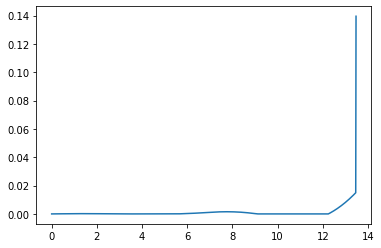

[ 7.23900939  8.15568097 12.59075376 12.87384351 13.04908955 13.18389419
 13.29173791 13.39958163 13.45350348]


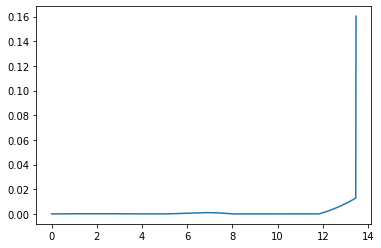

[ 6.94243917 12.30766401 12.63119515 12.86036305 13.02212862 13.17041373
 13.29173791 13.41306209 13.45350348]


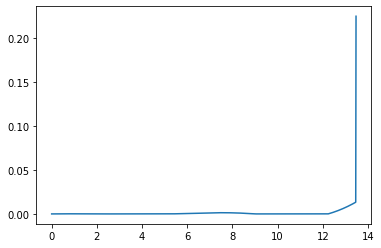

[ 7.198568    8.25004422 12.69859748 12.94124584 13.11649187 13.25129652
 13.3726207  13.45350348 13.46698395]


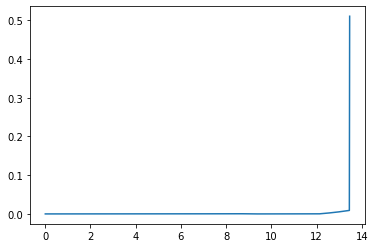

[12.44246865 12.87384351 13.11649187 13.30521837 13.45350348 13.45350348
 13.45350348 13.46698395 13.46698395]


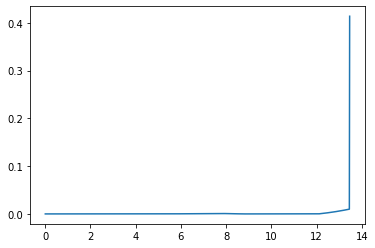

[ 7.85911075 12.65815608 12.9547263  13.17041373 13.3321793  13.45350348
 13.45350348 13.46698395 13.46698395]


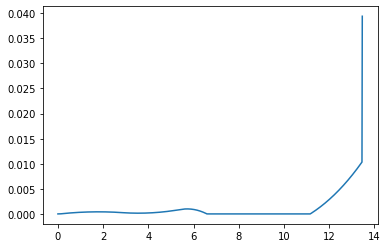

[ 4.89340858 11.43143382 12.10545704 12.44246865 12.68511701 12.88732398
 13.07605048 13.22433559 13.3726207 ]


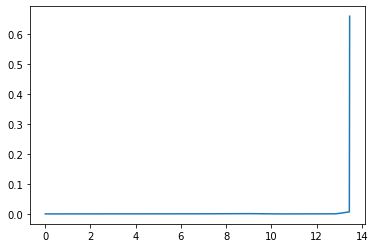

[ 8.47921211 13.00864816 13.3726207  13.45350348 13.45350348 13.45350348
 13.46698395 13.46698395 13.46698395]


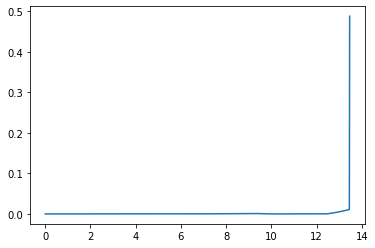

[ 9.07235255 12.87384351 13.12997234 13.30521837 13.44002302 13.45350348
 13.45350348 13.46698395 13.46698395]


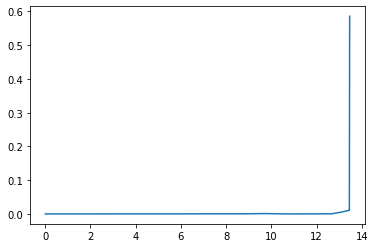

[10.16427017 13.10301141 13.29173791 13.44002302 13.45350348 13.45350348
 13.45350348 13.46698395 13.46698395]


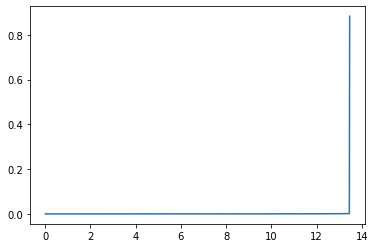

[13.26477698 13.45350348 13.45350348 13.45350348 13.45350348 13.46698395
 13.46698395 13.46698395 13.46698395]


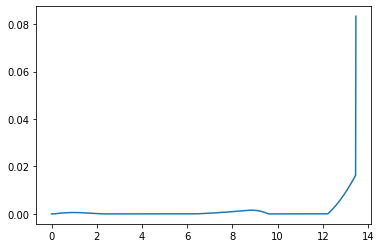

[ 7.83214982  8.91058698 12.59075376 12.84688258 13.00864816 13.1434528
 13.25129652 13.34565977 13.44002302]


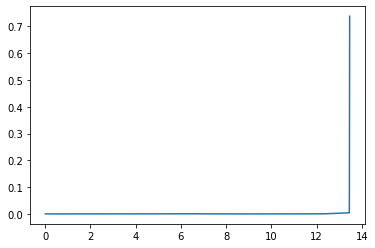

[12.65815608 13.23781605 13.45350348 13.45350348 13.45350348 13.45350348
 13.46698395 13.46698395 13.46698395]


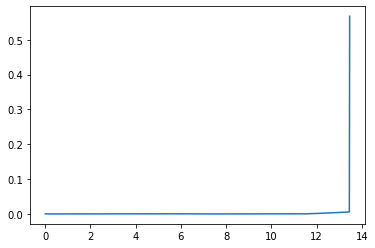

[12.26722261 12.7659998  13.10301141 13.3726207  13.45350348 13.45350348
 13.45350348 13.46698395 13.46698395]


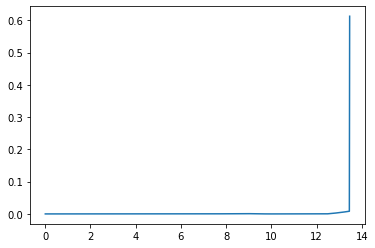

[ 9.46328602 13.04908955 13.29173791 13.45350348 13.45350348 13.45350348
 13.46698395 13.46698395 13.46698395]


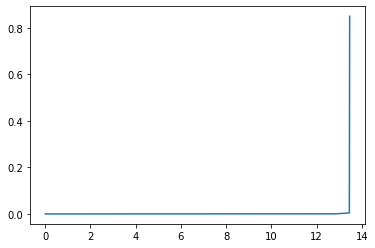

[13.27825745 13.45350348 13.45350348 13.45350348 13.45350348 13.46698395
 13.46698395 13.46698395 13.46698395]


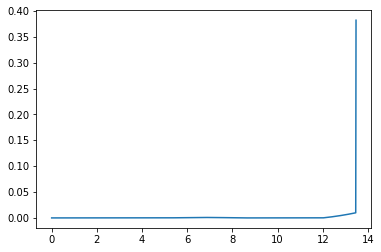

[ 7.17160707 12.56379283 12.88732398 13.10301141 13.27825745 13.42654255
 13.45350348 13.45350348 13.46698395]


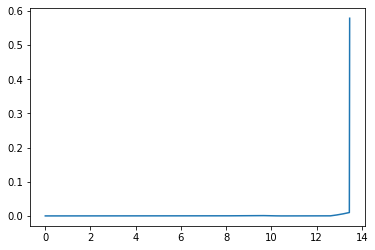

[ 9.53068834 13.03560909 13.26477698 13.42654255 13.45350348 13.45350348
 13.45350348 13.46698395 13.46698395]


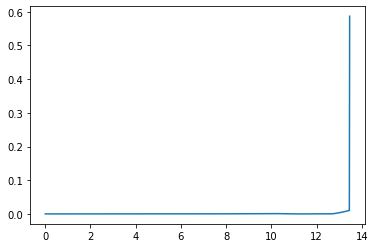

[ 9.89466088 13.04908955 13.27825745 13.44002302 13.45350348 13.45350348
 13.45350348 13.46698395 13.46698395]


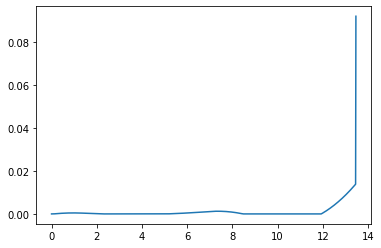

[ 6.84807592  8.04783725 12.52335144 12.7659998  12.9547263  13.10301141
 13.22433559 13.34565977 13.44002302]


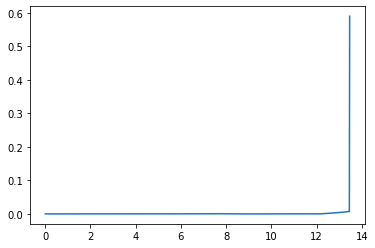

[12.37506633 12.94124584 13.22433559 13.44002302 13.45350348 13.45350348
 13.45350348 13.46698395 13.46698395]


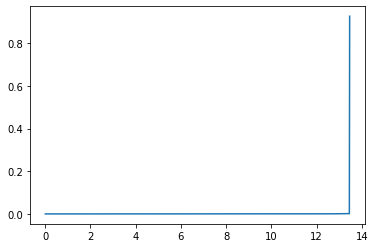

[13.45350348 13.45350348 13.45350348 13.45350348 13.45350348 13.46698395
 13.46698395 13.46698395 13.46698395]


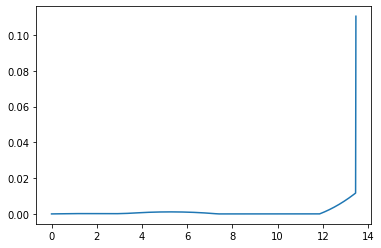

[ 4.59683836  5.82356063 12.22678122 12.63119515 12.87384351 13.06257001
 13.21085512 13.34565977 13.45350348]


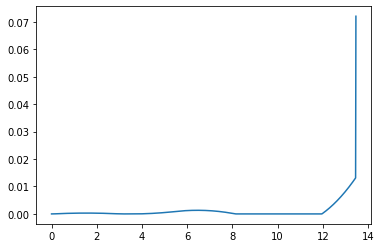

[ 5.67527552  6.75371267 12.25374215 12.64467562 12.87384351 13.04908955
 13.18389419 13.31869884 13.42654255]


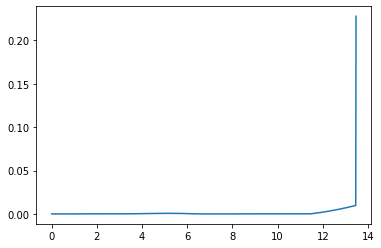

[ 5.6078732  12.18633983 12.55031237 12.80644119 13.02212862 13.19737466
 13.34565977 13.45350348 13.46698395]


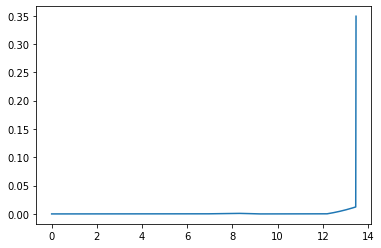

[ 8.47921211 12.69859748 12.9547263  13.12997234 13.27825745 13.39958163
 13.45350348 13.45350348 13.46698395]


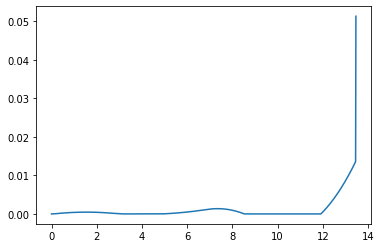

[ 6.33581827  7.52209914 12.32114447 12.65815608 12.87384351 13.03560909
 13.17041373 13.29173791 13.39958163]


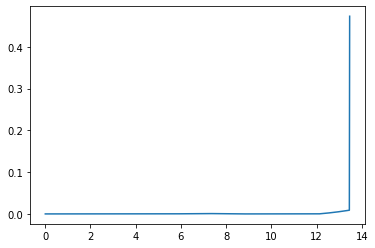

[ 7.73778657 12.7255584  13.02212862 13.23781605 13.41306209 13.45350348
 13.45350348 13.46698395 13.46698395]


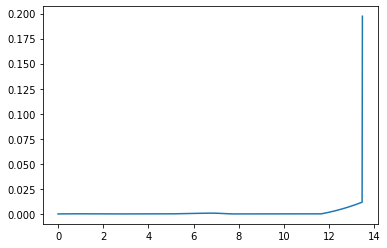

[11.66060172 12.37506633 12.65815608 12.87384351 13.04908955 13.19737466
 13.3321793  13.45350348 13.45350348]


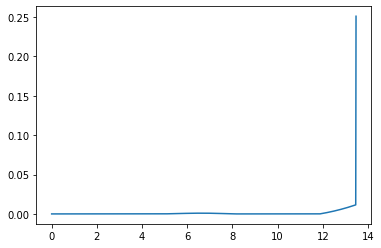

[ 6.88851731 12.40202726 12.7255584  12.94124584 13.11649187 13.26477698
 13.39958163 13.45350348 13.46698395]


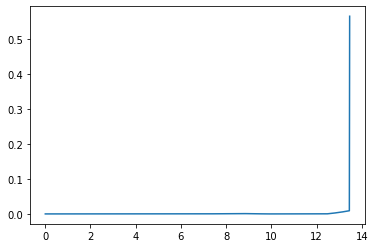

[ 8.95102837 12.96820676 13.22433559 13.39958163 13.45350348 13.45350348
 13.45350348 13.46698395 13.46698395]


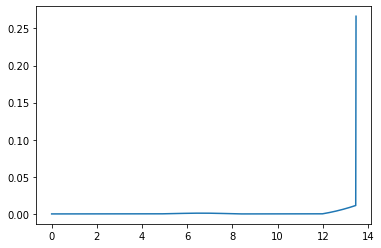

[ 6.69979081 12.3481054  12.7255584  12.9547263  13.12997234 13.27825745
 13.41306209 13.45350348 13.46698395]


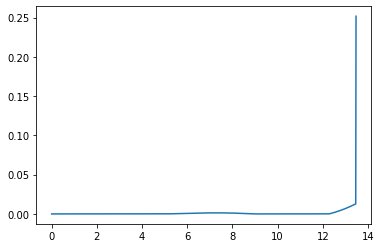

[ 6.90199778  7.93999354 12.69859748 12.96820676 13.1434528  13.27825745
 13.39958163 13.45350348 13.46698395]


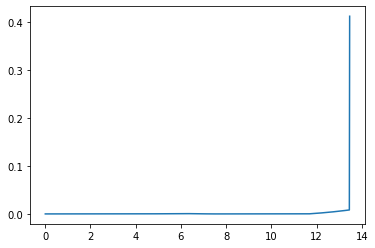

[11.9706524  12.55031237 12.87384351 13.10301141 13.30521837 13.45350348
 13.45350348 13.46698395 13.46698395]


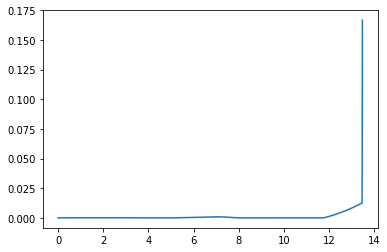

[ 7.23900939 12.3481054  12.64467562 12.86036305 13.03560909 13.17041373
 13.30521837 13.41306209 13.45350348]


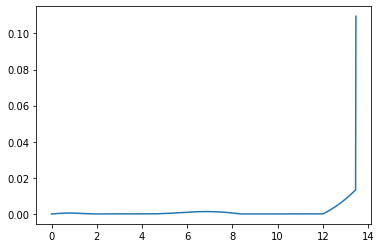

[ 6.24145502  7.31989218 12.44246865 12.75251933 12.9547263  13.10301141
 13.23781605 13.35914023 13.45350348]


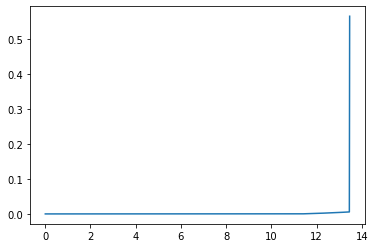

[12.25374215 12.75251933 13.08953094 13.3726207  13.45350348 13.45350348
 13.45350348 13.46698395 13.46698395]


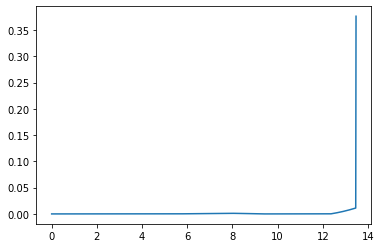

[ 7.46817728  8.88362605 12.90080444 13.12997234 13.29173791 13.42654255
 13.45350348 13.45350348 13.46698395]


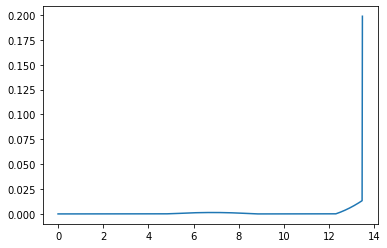

[ 6.33581827  7.30641171 12.5368319  12.87384351 13.07605048 13.22433559
 13.34565977 13.45350348 13.45350348]


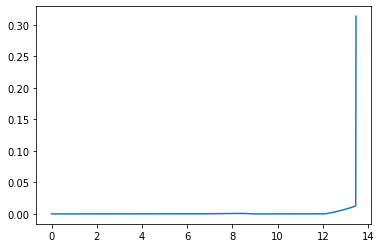

[ 8.45225119 12.65815608 12.90080444 13.08953094 13.23781605 13.35914023
 13.45350348 13.45350348 13.46698395]


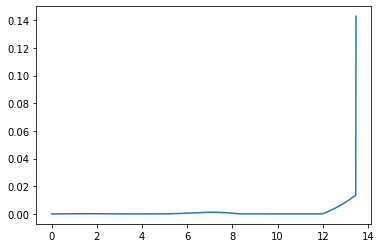

[ 6.88851731 12.18633983 12.61771469 12.84688258 13.02212862 13.15693327
 13.29173791 13.39958163 13.45350348]


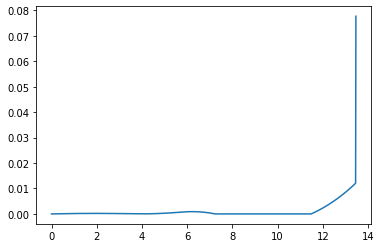

[ 6.20101363 12.06501565 12.42898819 12.67163655 12.87384351 13.03560909
 13.18389419 13.30521837 13.42654255]


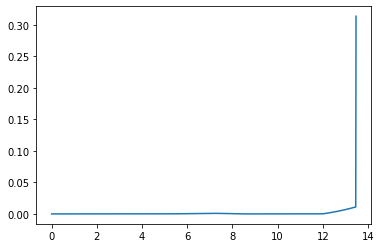

[ 7.26597032 12.49639051 12.81992166 13.03560909 13.19737466 13.34565977
 13.45350348 13.45350348 13.46698395]


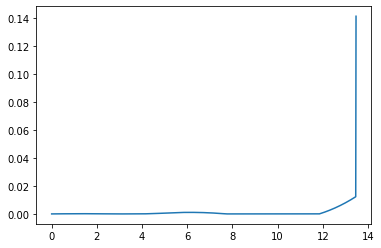

[ 5.93140434  7.50861868 12.50987097 12.77948026 12.96820676 13.12997234
 13.26477698 13.38610116 13.45350348]


In [27]:
#check which percentiles go in the anormal branch

print(len(index_weird))
print(index_weird)

lista=np.arange(90000,100000)[index_weird]

#check how the percentiles look


#plot_percentile_distribution(None,index_list=np.random.choice(lista, 10))


ms_weird=np.load('./input/ms_1e5_non_par.npy')[index_sh[90000:][index_weird],:]
t=np.load('./input/t_1e5_non_par.npy')

#check how the mass curves look

for i in range(50): #len(index_weird)):
    plt.plot(t,ms_weird[i,:])
    plt.show()
    print(percentiles[index_sh[90000:][index_weird][i],:])
    

See how many values outside each interval of confidence (for at least one percentile or averaging )

In [12]:
#fraction of galaxies with at least 1 percentil with error outside the 1sigma interval

stds=np.array(stds)
means=np.array(means)
#n_evaluations=2000

indexes=[]
for k,j in enumerate(index_list):
    #print('k:', k)
    for i in range(9):
        #print('i: ',i)
        if stds[k,i]<(np.abs(means[k,i]-percentiles[index_sh[j],i])):
            indexes.append(j)
            break

print('Fraction of galaxies with at least 1 percentil with error outside the 1sigma interval')
print(len(indexes)/n_evaluations * 100, '%')


      
#fraction of galaxies with at least 1 percentil with error outside the 2sigma interval

indexes=[]
for k,j in enumerate(index_list):
    for i in range(9):
        if 2*stds[k,i]<(np.abs(means[k,i]-percentiles[index_sh[j],i])):
            indexes.append(j)
            break

print('Fraction of galaxies with at least 1 percentil with error outside the 2sigma interval')
print(len(indexes)/n_evaluations * 100, '%')

#the same but averaged between all percentiles

#sigma
indexes=[]
for k,j in enumerate(index_list):
        if np.mean(stds[k,:])<np.mean(np.abs(means[k,:]-percentiles[index_sh[j],:])):
            indexes.append(j)

print('Fraction of galaxies with averaged error outside the averaged 1sigma interval')
print(len(indexes)/n_evaluations * 100, '%')

#2sigma
indexes=[]
for k,j in enumerate(index_list):
        if 2*np.mean(stds[k,:])<np.mean(np.abs(means[k,:]-percentiles[index_sh[j],:])):
            indexes.append(j)
            
print('Fraction of galaxies with averaged error outside the averaged 2sigma interval')
print(len(indexes)/n_evaluations * 100, '%')





Fraction of galaxies with at least 1 percentil with error outside the 1sigma interval
60.14000000000001 %
Fraction of galaxies with at least 1 percentil with error outside the 2sigma interval
15.03 %
Fraction of galaxies with averaged error outside the averaged 1sigma interval
19.18 %
Fraction of galaxies with averaged error outside the averaged 2sigma interval
1.58 %


Corner plot

0it [00:00, ?it/s]

index:  27557


1it [00:06,  6.45s/it]

index:  35659


2it [00:10,  4.91s/it]

index:  45960


3it [00:13,  4.28s/it]

index:  5057


4it [00:17,  4.12s/it]

index:  44252


5it [00:21,  4.37s/it]


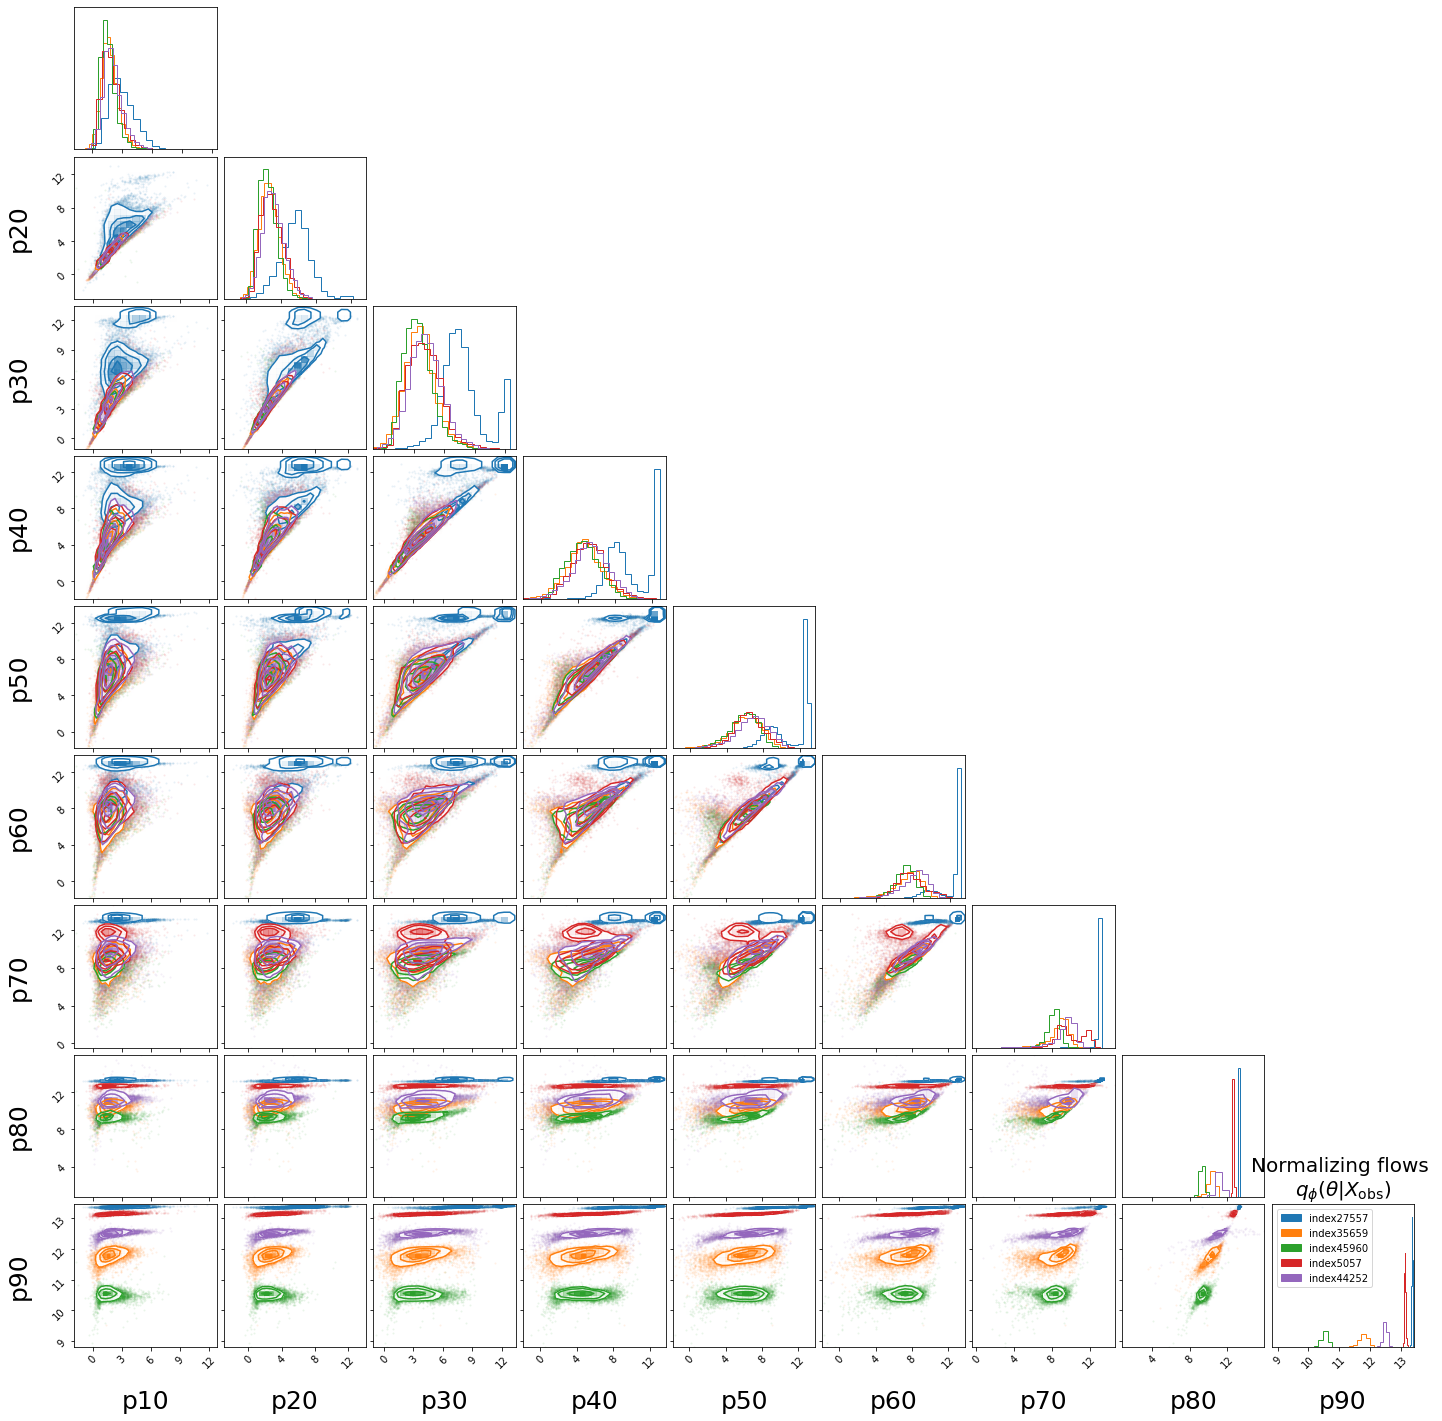

In [13]:
#all percentiles together

import corner

best_list=np.random.randint(90000,100000,5)

fig=plt.figure(figsize=(20,20))

posteriors=[]

for k,j in tqdm(enumerate(best_list)):
    print('index: ',index_sh[j])
    Xobs=latents[index_sh[j],:]
    posterior_samples = np.array(qphi.sample((10000,), 
                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                    show_progress_bars=False).detach().to('cpu'))
    posteriors.append(posterior_samples)
    #qphi sample is the number of datapoints you want in the plot                            
    #print(np.shape(posterior_samples))

    lt=['p'+str(i*10) for i in range(1,10)] #label for percentiles

    #we plot all the percentiles
    _ = corner.corner(posterior_samples[:,:], 
                      labels=lt,
                      label_kwargs={'fontsize': 25},
                      color='C'+str(k), hist_kwargs={'density': True},fig=fig)
    plt.fill_between([], [], [], color='C'+str(k), label="index"+str(index_sh[j]))
    
plt.legend(loc='upper left', fontsize=10)
plt.title('Normalizing flows \n'+ r'$q_\phi(\theta|X_{\rm obs})$',fontsize=20)
plt.show()